In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%cd /content/drive/MyDrive/Generative_AI
#!git config --global user.email "jdcastromi@gmail.com"
#!git config --global user.name "jdiego-miyashiro"
#!git add . 
#!git commit -m "first commit on this branch"

/content/drive/MyDrive/Generative_AI


[colab_branch 3d86a5e] first commit on this branch
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 vqvae.h5


In [ ]:
#!git push --set-upstream origin colab_branch

fatal: could not read Username for 'https://github.com': No such device or address


In [1]:
!nvidia-smi"

Tue May 16 18:51:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P3    15W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import pathlib
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU,Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import pathlib
import matplotlib.pyplot as plt

2023-05-17 15:16:49.919915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 15:16:50.983592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-17 15:16:50.983696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-17 15:16:50.983708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
img_height = 128
img_width = 128
batch_size = 32

### Creating tf.Datasets

In [6]:

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)/255
  return img,

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


In [7]:
list_ds = tf.data.Dataset.list_files('data_dir''*/*', shuffle=False)
val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.3)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [8]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        
        

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [9]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

## Build the VQ-VAE

In [24]:
embedding_dim = 10             # The number 
num_embeddings = 512

## Define Resnet Encoder

In [25]:


def resnet_encoder(input_shape, num_filters, latent_dim):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # downsample via strided convolutions
    #x = resnet_block(x, num_filters, strides=2)
    #x = resnet_block(x, num_filters, strides=1)
    x = resnet_block(x, num_filters * 4, strides=2)
    x = resnet_block(x, num_filters * 2, strides=1)

    # final conv layer
    x = tf.keras.layers.Conv2D(latent_dim, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.LayerNormalization()(x)

    model = tf.keras.Model(inputs, x, name='Encoder')
    return model


def resnet_block(inputs, filters, strides=1):
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)

    shortcut = inputs
    if strides != 1 or inputs.shape[3] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='valid')(inputs)

    x = tf.keras.layers.Add()([x, shortcut])
    return x




In [26]:
encoder_model = resnet_encoder(input_shape=(128, 128, 3), num_filters=64, latent_dim=embedding_dim)
encoder_model.summary()


Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                            

## Define Deconvolutional Generator (From DCGAN: https://arxiv.org/abs/1511.06434)

In [27]:
encoder_output_shape = encoder_model.layers[-1].output_shape[1:]

In [28]:
def tanh_plus_one(x):
    return tf.keras.activations.tanh(x) + 1.0

def dcgenerator(encoder_output_shape):
    # Input shape: (32, 32, 1)
    inputs = tf.keras.layers.Input(shape=encoder_output_shape)

    # Upsample to (64, 64, 512)
    x = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Upsample to (128, 128, 256)
    x = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    
    # Upsample to (64, 64, 32)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Upsample to (128, 128, 16)
    x = tf.keras.layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Upsample to (256, 256, 3)
    outputs = tf.keras.layers.Conv2D(3, (4, 4), strides=(1, 1), padding='same', activation=tanh_plus_one, use_bias=True)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs,name='Decoder')

    return model


In [29]:

decoder_model = dcgenerator(encoder_output_shape)

In [30]:
decoder_model.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 10)]      0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 64, 64, 512)      81920     
 ranspose)                                                       
                                                                 
 batch_normalization_23 (Bat  (None, 64, 64, 512)      2048      
 chNormalization)                                                
                                                                 
 re_lu_8 (ReLU)              (None, 64, 64, 512)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 256)    2097152   
 ranspose)                                                       
                                                           

## Define the VQVAE Architecture (Putting Resnet Encoder + Codebook + DC Decoder)

In [31]:
def build_vqvae(num_embeddings=512,embedding_dim=32):
    encoder_output_shape = encoder_model.layers[-1].output_shape[1:]
    vq_layer = VectorQuantizer(num_embeddings, embedding_dim, name="vector_quantizer")
    encoder = resnet_encoder(input_shape=(128, 128, 3), num_filters=64, latent_dim=embedding_dim)
    decoder = dcgenerator(encoder_output_shape)

    inputs = keras.Input(shape=(128, 128, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    vqvae_model = keras.Model(inputs, reconstructions, name="vq_vae")
    
    return vqvae_model

## Wrap the architecture in a tf.keras.models.Model class to define the custom training procedure

In [32]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = build_vqvae(embedding_dim=self.latent_dim, num_embeddings=self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)


            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) 
            )
            total_loss = reconstruction_loss + 0.8*sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


### Training

In [33]:
embedding_dim

10

In [37]:
vqvae_trainer = VQVAETrainer(latent_dim=embedding_dim, num_embeddings=num_embeddings)

In [38]:
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 Encoder (Functional)        (None, 32, 32, 10)        1243806   
                                                                 
 vector_quantizer (VectorQua  (None, 32, 32, 10)       5120      
 ntizer)                                                         
                                                                 
 Decoder (Functional)        (None, 128, 128, 3)       2841347   
                                                                 
Total params: 4,090,273
Trainable params: 4,086,817
Non-trainable params: 3,456
_________________________________________________________________


In [45]:
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(0.0002))
history = vqvae_trainer.fit(train_ds
                  ,epochs=100)


Epoch 1/100
95/95 [==============================] - 34s 284ms/step - loss: 0.0331 - reconstruction_loss: 0.0078 - vqvae_loss: 0.0277
Epoch 2/100
95/95 [==============================] - 27s 287ms/step - loss: 0.0128 - reconstruction_loss: 0.0056 - vqvae_loss: 0.0091
Epoch 3/100
95/95 [==============================] - 27s 285ms/step - loss: 0.0128 - reconstruction_loss: 0.0055 - vqvae_loss: 0.0092
Epoch 4/100
95/95 [==============================] - 27s 286ms/step - loss: 0.0126 - reconstruction_loss: 0.0054 - vqvae_loss: 0.0090
Epoch 5/100
95/95 [==============================] - 27s 286ms/step - loss: 0.0127 - reconstruction_loss: 0.0055 - vqvae_loss: 0.0090
Epoch 6/100
95/95 [==============================] - 27s 286ms/step - loss: 0.0122 - reconstruction_loss: 0.0054 - vqvae_loss: 0.0087
Epoch 7/100
95/95 [==============================] - 27s 285ms/step - loss: 0.0126 - reconstruction_loss: 0.0055 - vqvae_loss: 0.0090
Epoch 8/100
95/95 [==============================] - 27s 284ms

KeyboardInterrupt: 

In [46]:
vqvae_trainer.vqvae.save_weights('vqvae_32_32_10.h5')

In [47]:
test = next(iter(val_ds))
train = next(iter(train_ds))

2023-05-17 16:29:23.576556: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [48]:
out = vqvae_trainer.vqvae(test)

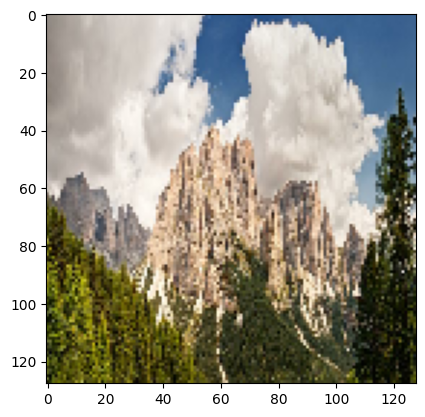

In [52]:
plt.imshow(test[0][-1])

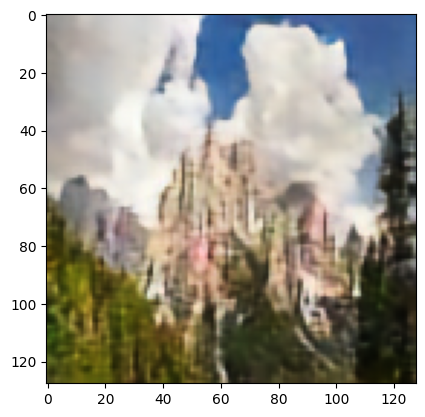

In [51]:
plt.imshow(out[-1])